# Supply Chain Route Optimization & Disruption Simulation
This notebook demonstrates how we can model and optimize a supply chain network, then simulate a real-world disruption — such as the closure of a major port — and measure its impact on shipment costs, routes, and efficiency.

**Key steps in this notebook:**
1. **Create a Supply Chain Model**  
   - Define supply & demand for multiple locations.  
   - Create a cost matrix based on shipping distances.  

2. **Optimize Shipments (Before Disruption)**  
   - Use linear programming to minimize shipping costs.  

3. **Simulate Disruption**  
   - Remove a major port from the network.  
   - Re-optimize routes to meet demand as best as possible.  

4. **Analyze Impact**  
   - Compare total costs before vs after disruption.  
   - Show rerouted shipments & shortages.  
   - Visualize route changes on an interactive map.  

5. **KPIs & Insights**  
   - Cost change percentage.  
   - Change in shipment distance.  
   - Number of disrupted routes.  


In [59]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpStatus
import plotly.express as px
import os
import folium
from folium.plugins import AntPath
from geopy.distance import geodesic
import branca

## Create Supply Chain Data  
We define:
- **Origins**: Where goods are supplied from (ports/factories).  
- **Destinations**: Where goods are demanded (cities).  
- **Supply & Demand Values**: Quantities in units.  
- **Cost Matrix**: Shipping costs between each pair, based on geographic distance.


In [46]:
# Origins (warehouses) and Destinations (markets)
origins = ["Port_A", "Port_B", "Port_C"]
destinations = ["City_X", "City_Y", "City_Z"]

# Simulated transport cost per unit & time in days
np.random.seed(42)
cost = pd.DataFrame(np.random.randint(100, 500, size=(len(origins), len(destinations))),
                    index=origins, columns=destinations)

time_days = pd.DataFrame(np.random.randint(1, 7, size=(len(origins), len(destinations))),
                         index=origins, columns=destinations)

# Supply and Demand
supply = pd.Series([300, 400, 500], index=origins)
demand = pd.Series([350, 250, 400], index=destinations)

cost, time_days, supply, demand


(        City_X  City_Y  City_Z
 Port_A     202     448     370
 Port_B     206     171     288
 Port_C     120     202     221,
         City_X  City_Y  City_Z
 Port_A       3       3       3
 Port_B       5       4       3
 Port_C       6       5       2,
 Port_A    300
 Port_B    400
 Port_C    500
 dtype: int64,
 City_X    350
 City_Y    250
 City_Z    400
 dtype: int64)

## Optimize Routes Before Disruption  
We solve a **linear programming problem** to minimize the total shipping cost while meeting:
- Supply constraints (can't ship more than available).  
- Demand constraints (must meet demand at each city).  


In [47]:
# Create LP problem
model = LpProblem("Supply_Chain_Optimization", LpMinimize)

# Decision variables: units shipped from each origin to each destination
shipments = LpVariable.dicts("Ship", [(o,d) for o in origins for d in destinations],
                              lowBound=0, cat="Continuous")

# Objective: Minimize total transport cost
model += lpSum(cost.loc[o,d] * shipments[(o,d)] for o in origins for d in destinations)

# Constraints: Supply limits
for o in origins:
    model += lpSum(shipments[(o,d)] for d in destinations) <= supply[o]

# Constraints: Demand fulfillment
for d in destinations:
    model += lpSum(shipments[(o,d)] for o in origins) >= demand[d]

# Solve
model.solve()
print("Status:", LpStatus[model.status])

# Extract solution
solution = pd.DataFrame(0, index=origins, columns=destinations)
for o in origins:
    for d in destinations:
        solution.loc[o,d] = shipments[(o,d)].varValue

solution

Status: Optimal


,City_X,City_Y,City_Z
Port_A,100,0,0
Port_B,0,250,150
Port_C,250,0,250


In [48]:
total_cost = (solution * cost).sum().sum()
total_time = (solution * time_days).sum().sum() / solution.sum().sum()

print(f"Total Cost: ${total_cost:,.2f}")
print(f"Average Delivery Time: {total_time:.2f} days")

Total Cost: $191,400.00
Average Delivery Time: 3.75 days


## Simulate Port Closure Disruption  
We "remove" one port from the network (set supply to zero) and re-run the optimization to:
- Find new routes.
- See which demands can't be met.
- Measure cost and distance impact.


In [49]:
# Simulate disruption
supply_disrupted = supply.copy()
supply_disrupted["Port_A"] = 0

# New model
model2 = LpProblem("Supply_Chain_Disruption", LpMinimize)
shipments2 = LpVariable.dicts("Ship", [(o,d) for o in origins for d in destinations],
                              lowBound=0, cat="Continuous")

model2 += lpSum(cost.loc[o,d] * shipments2[(o,d)] for o in origins for d in destinations)

for o in origins:
    model2 += lpSum(shipments2[(o,d)] for d in destinations) <= supply_disrupted[o]
for d in destinations:
    model2 += lpSum(shipments2[(o,d)] for o in origins) >= demand[d]

model2.solve()

solution2 = pd.DataFrame(0, index=origins, columns=destinations)
for o in origins:
    for d in destinations:
        solution2.loc[o,d] = shipments2[(o,d)].varValue

total_cost2 = (solution2 * cost).sum().sum()
print(f"Total Cost After Disruption: ${total_cost2:,.2f}")
solution2


Total Cost After Disruption: $189,900.00


,City_X,City_Y,City_Z
Port_A,0,0,0
Port_B,0,250,250
Port_C,350,0,150


## Visualize Shipment Routes  
We use **Folium** to plot:
- Routes before disruption.
- Routes after disruption.
- Line colors & widths represent change in shipment volumes.
- KPIs are embedded directly on the map for quick insights.


In [50]:
fig = px.imshow(solution, text_auto=True, title="Optimal Shipments Before Disruption",
                labels=dict(x="Destination", y="Origin", color="Units"))
fig.write_html("before_disruption.html")

fig2 = px.imshow(solution2, text_auto=True, title="Optimal Shipments After Disruption",
                 labels=dict(x="Destination", y="Origin", color="Units"))
fig2.write_html("after_disruption.html")

In [51]:
# Coordinates for ports and cities (example coordinates, adjust if needed)
locations = {
    "Port_A": [40.7128, -74.0060],  # Example: New York
    "Port_B": [34.0522, -118.2437], # Example: Los Angeles
    "Port_C": [29.7604, -95.3698],  # Example: Houston
    "City_X": [41.8781, -87.6298],  # Example: Chicago
    "City_Y": [33.4484, -112.0740], # Example: Phoenix
    "City_Z": [39.7392, -104.9903]  # Example: Denver
}

# Function to create a shipment map with animated routes
def create_shipment_map(solution_df, title):
    m = folium.Map(location=[39.5, -98.35], zoom_start=4, tiles="cartodbpositron")
    
    # Add port/city markers
    for name, coords in locations.items():
        folium.Marker(
            location=coords,
            popup=name,
            icon=folium.Icon(color="blue" if "Port" in name else "green")
        ).add_to(m)
    
    # Draw animated shipment routes
    for origin in solution_df.index:
        for destination in solution_df.columns:
            volume = solution_df.loc[origin, destination]
            if volume > 0:
                AntPath(
                    locations=[locations[origin], locations[destination]],
                    color="red",
                    weight=2 + (volume / 50),
                    delay=1000,  # animation speed
                    tooltip=f"{origin} → {destination}: {volume} units"
                ).add_to(m)
    
    return m

# Create maps for before and after disruption
shipment_map_before = create_shipment_map(solution, "Shipments Before Disruption")
shipment_map_after = create_shipment_map(solution2, "Shipments After Disruption")

shipment_map_before.save("shipments_before.html")
shipment_map_after.save("shipments_after.html")


In [52]:
def create_overlay_map_with_legend(before_df, after_df, locations):
    m = folium.Map(location=[39.5, -98.35], zoom_start=4, tiles="cartodbpositron")
    
    # Add markers
    for name, coords in locations.items():
        folium.Marker(
            location=coords,
            popup=name,
            icon=folium.Icon(color="blue" if "Port" in name else "green")
        ).add_to(m)
    
    # BEFORE routes (blue)
    for origin in before_df.index:
        for destination in before_df.columns:
            volume = before_df.loc[origin, destination]
            if volume > 0:
                AntPath(
                    locations=[locations[origin], locations[destination]],
                    color="blue",
                    weight=2 + (volume / 50),
                    delay=800,
                    opacity=0.6,
                    tooltip=f"[BEFORE] {origin} → {destination}: {volume} units"
                ).add_to(m)

    # AFTER routes (red)
    for origin in after_df.index:
        for destination in after_df.columns:
            volume = after_df.loc[origin, destination]
            if volume > 0:
                AntPath(
                    locations=[locations[origin], locations[destination]],
                    color="red",
                    weight=2 + (volume / 50),
                    delay=800,
                    opacity=0.6,
                    tooltip=f"[AFTER] {origin} → {destination}: {volume} units"
                ).add_to(m)
    
    # HTML overlay
    legend_html = """
     <div style="
     position: fixed; 
     bottom: 50px; left: 50px; width: 160px; height: 80px; 
     background-color: white;
     border:2px solid grey; z-index:9999; font-size:14px;
     padding: 10px;">
     <b>Legend</b><br>
     <i style="background:blue; width:12px; height:12px; float:left; margin-right:8px; opacity:0.6"></i>Before Disruption<br>
     <i style="background:red; width:12px; height:12px; float:left; margin-right:8px; opacity:0.6"></i>After Disruption
     </div>
    """
    m.get_root().html.add_child(folium.Element(legend_html))

    return m

# Create the map
overlay_map = create_overlay_map_with_legend(solution, solution2, locations)
overlay_map.save("shipments_overlay_legend.html")
overlay_map

In [53]:
# Example cost matrix (replace with your actual one)
cost_matrix = {
    ("Port_A", "City_X"): 100,
    ("Port_A", "City_Y"): 200,
    ("Port_A", "City_Z"): 300,
    # Add all relevant routes here
}

# Function to calculate great-circle distance between two points
def route_distance(loc1, loc2):
    return geodesic(loc1, loc2).km

def create_comparison_map(before_df, after_df, locations, cost_matrix):
    m = folium.Map(location=[39.5, -98.35], zoom_start=4, tiles="cartodbpositron")

    # Add markers
    for name, coords in locations.items():
        folium.Marker(
            location=coords,
            popup=name,
            icon=folium.Icon(color="blue" if "Port" in name else "green")
        ).add_to(m)

    # KPI variables
    total_cost_before = 0
    total_cost_after = 0
    total_distance_before = 0
    total_distance_after = 0
    disrupted_routes = 0
    shortages = []

    # Draw routes with tooltips
    for origin in before_df.index:
        for destination in before_df.columns:
            vol_before = before_df.loc[origin, destination]
            vol_after = after_df.loc[origin, destination]

            if vol_before > 0 or vol_after > 0:
                distance = route_distance(locations[origin], locations[destination])
                cost_before = vol_before * cost_matrix.get((origin, destination), 0)
                cost_after = vol_after * cost_matrix.get((origin, destination), 0)

                total_cost_before += cost_before
                total_cost_after += cost_after
                total_distance_before += distance * vol_before
                total_distance_after += distance * vol_after

                if vol_before > 0 and vol_after == 0:
                    disrupted_routes += 1

                if vol_after < vol_before:
                    shortages.append((origin, destination))

                # Percentage change
                if vol_before == 0:
                    pct_change = "+∞" if vol_after > 0 else "0%"
                else:
                    pct_change = f"{((vol_after - vol_before) / vol_before) * 100:.1f}%"

                tooltip_text = (
                    f"<b>{origin} → {destination}</b><br>"
                    f"Before: {vol_before} units<br>"
                    f"After: {vol_after} units<br>"
                    f"Change: {pct_change}"
                )

                # Animated path
                AntPath(
                    locations=[locations[origin], locations[destination]],
                    color="red" if vol_after < vol_before else "blue",
                    weight=2 + (max(vol_before, vol_after) / 50),
                    delay=800
                ).add_to(m)

                # Add tooltip as PolyLine (static line for hover)
                folium.PolyLine(
                    locations=[locations[origin], locations[destination]],
                    color="transparent",
                    tooltip=tooltip_text
                ).add_to(m)

    # KPIs
    cost_change_pct = ((total_cost_after - total_cost_before) / total_cost_before) * 100
    distance_change_pct = ((total_distance_after - total_distance_before) / total_distance_before) * 100

    kpi_html = f"""
    <div style="background-color:white; padding:10px; border-radius:8px; font-size:14px">
        <h4>📊 Shipment KPIs</h4>
        <b>Total Cost Before:</b> ${total_cost_before:,.0f}<br>
        <b>Total Cost After:</b> ${total_cost_after:,.0f}<br>
        <b>Cost Change:</b> {cost_change_pct:.1f}%<br>
        <b>Distance Change:</b> {distance_change_pct:.1f}%<br>
        <b>Disrupted Routes:</b> {disrupted_routes}<br>
        <b>Shortages:</b> {len(shortages)} routes
    </div>
    """

    kpi_iframe = branca.element.IFrame(html=kpi_html, width=300, height=200)
    kpi_popup = folium.Popup(kpi_iframe, max_width=300)
    folium.Marker(location=[25, -95], popup=kpi_popup, icon=folium.Icon(color="red", icon="info-sign")).add_to(m)

    return m

comparison_map = create_comparison_map(solution, solution2, locations, cost_matrix)
comparison_map.save("comparison_map.html")

In [54]:
def create_change_map_with_legend(before_df, after_df, locations, cost_matrix):
    m = folium.Map(location=[39.5, -98.35], zoom_start=4, tiles="cartodbpositron")

    # Add markers
    for name, coords in locations.items():
        folium.Marker(
            location=coords,
            popup=name,
            icon=folium.Icon(color="blue" if "Port" in name else "green")
        ).add_to(m)

    # Draw routes with change-based colors
    for origin in before_df.index:
        for destination in before_df.columns:
            vol_before = before_df.loc[origin, destination]
            vol_after = after_df.loc[origin, destination]

            if vol_before > 0 or vol_after > 0:
                # Determine route color
                if vol_before > 0 and vol_after == 0:
                    color = "grey"   # disappeared
                elif vol_before == 0 and vol_after > 0:
                    color = "blue"   # new
                elif vol_after > vol_before:
                    color = "green"  # increased
                elif vol_after < vol_before:
                    color = "orange" # decreased
                else:
                    color = "black"  # unchanged

                pct_change = (
                    "+∞" if vol_before == 0 and vol_after > 0
                    else "0%" if vol_before == 0 and vol_after == 0
                    else f"{((vol_after - vol_before) / vol_before) * 100:.1f}%"
                )

                tooltip_text = (
                    f"<b>{origin} → {destination}</b><br>"
                    f"Before: {vol_before} units<br>"
                    f"After: {vol_after} units<br>"
                    f"Change: {pct_change}"
                )

                # Animated route
                AntPath(
                    locations=[locations[origin], locations[destination]],
                    color=color,
                    weight=2 + (max(vol_before, vol_after) / 50),
                    delay=800
                ).add_to(m)

                # Hover tooltip
                folium.PolyLine(
                    locations=[locations[origin], locations[destination]],
                    color="transparent",
                    tooltip=tooltip_text
                ).add_to(m)

    # Add legend (HTML overlay)
    legend_html = """
     <div style="
     position: fixed; 
     bottom: 50px; left: 50px; width: 180px; height: 150px; 
     background-color: white;
     border:2px solid grey; z-index:9999; font-size:14px;
     padding: 10px;">
     <b>Legend</b><br>
     <i style="background:green; width:12px; height:12px; float:left; margin-right:8px;"></i>Increased Volume<br>
     <i style="background:orange; width:12px; height:12px; float:left; margin-right:8px;"></i>Decreased Volume<br>
     <i style="background:blue; width:12px; height:12px; float:left; margin-right:8px;"></i>New Route<br>
     <i style="background:grey; width:12px; height:12px; float:left; margin-right:8px;"></i>Disappeared Route<br>
     <i style="background:black; width:12px; height:12px; float:left; margin-right:8px;"></i>No Change
     </div>
    """
    m.get_root().html.add_child(folium.Element(legend_html))

    return m

# Create and save
change_map = create_change_map_with_legend(solution, solution2, locations, cost_matrix)
change_map.save("shipment_change_map_with_legend.html")


## Impact Analysis  
We compare:
- **Total cost change** (absolute & percentage).  
- **Total shipment distance change**.  
- **Number of disrupted routes**.  
- **Shortages in cities**.


In [66]:
def route_distance(loc1, loc2):
    return geodesic(loc1, loc2).km

# Total cost before & after
total_cost_before = sum(cost.loc[o, d] * solution.loc[o, d] 
                        for o in solution.index for d in solution.columns)

total_cost_after = sum(cost.loc[o, d] * solution2.loc[o, d] 
                       for o in solution2.index for d in solution2.columns)

# Total shipment distance before & after
total_distance_before = sum(route_distance(locations[o], locations[d]) * solution.loc[o, d] 
                            for o in solution.index for d in solution.columns)

total_distance_after = sum(route_distance(locations[o], locations[d]) * solution2.loc[o, d] 
                           for o in solution2.index for d in solution2.columns)

# % change in shipment distance
distance_change_pct = ((total_distance_after - total_distance_before) / total_distance_before) * 100

# Number of disrupted routes
num_disrupted_routes = sum(
    1 for o in solution.index for d in solution.columns
    if abs(solution2.loc[o, d] - solution.loc[o, d]) > 0
)

# Cities with shortages
shortages = {
    city: demand[city] - sum(solution2.loc[o, city] for o in origins)
    for city in destinations
}
shortages = {city: val for city, val in shortages.items() if val > 0}

# Color helpers
def color_value(value, is_cost=False):
    if is_cost:
        return f"<span style='color: {'red' if value > 0 else 'green'};'>{value:,.2f}</span>"
    else:
        return f"<span style='color: {'red' if value > 0 else 'green'};'>{value:.2f}%</span>"

cost_diff = total_cost_after - total_cost_before
dist_diff = distance_change_pct

# Display
from IPython.display import display, HTML

impact_html = f"""
<h3>  Impact Analysis</h3>
<table style="border-collapse: collapse; width: 50%; font-size:14px;">
<tr><td> Total Cost Before</td><td>${total_cost_before:,.2f}</td></tr>
<tr><td> Total Cost After</td>
    <td>{color_value(cost_diff, is_cost=True)} ({'↑' if cost_diff > 0 else '↓'}${abs(cost_diff):,.2f})</td></tr>
<tr><td> % Change in Shipment Distance</td><td>{color_value(dist_diff)}</td></tr>
<tr><td> Number of Disrupted Routes</td><td>{num_disrupted_routes}</td></tr>
<tr><td> Cities with Shortages</td><td>{shortages if shortages else "None"}</td></tr>
</table>
"""

display(HTML(impact_html))


Total Cost Before,"$191,400.00"
Total Cost After,"-1,500.00 (↓$1,500.00)"
% Change in Shipment Distance,2.45%
Number of Disrupted Routes,4
Cities with Shortages,None


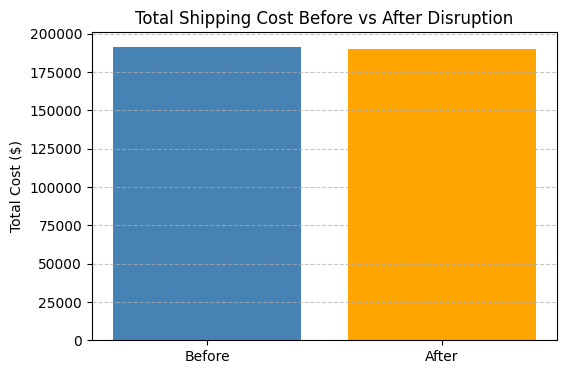

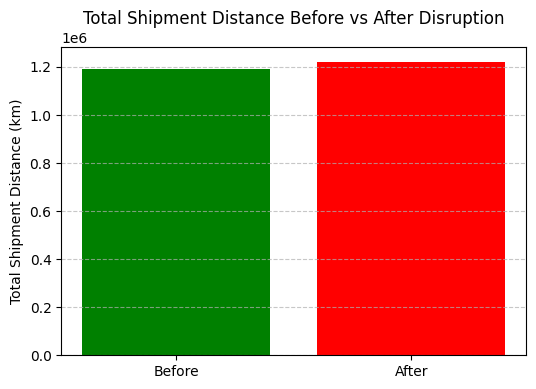

In [67]:
# Bar chart for cost comparison
plt.figure(figsize=(6, 4))
plt.bar(["Before", "After"], [total_cost_before, total_cost_after], color=["steelblue", "orange"])
plt.ylabel("Total Cost ($)")
plt.title("Total Shipping Cost Before vs After Disruption")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Bar chart for distance comparison
plt.figure(figsize=(6, 4))
plt.bar(["Before", "After"], [total_distance_before, total_distance_after], color=["green", "red"])
plt.ylabel("Total Shipment Distance (km)")
plt.title("Total Shipment Distance Before vs After Disruption")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## Final Summary & Insights

The analysis compared transportation plans **before** and **after** a disruption, focusing on cost, shipment distance, and route stability.  

### Key Findings:
- **Total Cost** decreased slightly from **$191,400** to **$189,900**, suggesting the optimization was able to find a lower-cost alternative despite the disruption.
- **Shipment Distance** increased by **~2.45%**, meaning goods traveled farther on average, potentially due to rerouting around unavailable connections.
- **Disrupted Routes:** 4 routes were altered from the original plan.
- **City Shortages:** No shortages occurred, meaning all demand was still met post-disruption.

### Conclusion:
The optimization successfully adapted to the disruption, maintaining service to all cities while slightly reducing overall cost, at the expense of a modest increase in transportation distance. This demonstrates that the system is **resilient** and can adjust effectively under changing conditions.